Célula 1: Importação das Bibliotecas

Esta célula carrega todas as ferramentas necessárias.

In [10]:
# Importação das bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

# Ferramentas do Scikit-Learn
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Configuração de estilo para os gráficos
sns.set(style="whitegrid")
%matplotlib inline

Célula 2: Carregamento dos Dados

Esta célula baixa o dataset diretamente da fonte e o carrega em um DataFrame.

In [11]:
# Baixando o dataset do repositório UCI (comando específico para Colab/Linux)
!wget -q -c http://archive.ics.uci.edu/ml/machine-learning-databases/00267/data_banknote_authentication.txt

# Carregando os dados
colunas = ["variance", "skewness", "curtosis", "entropy", "class"]
df = pd.read_csv("data_banknote_authentication.txt", names=colunas, header=None)

# Visualizando as primeiras linhas
print("Amostra dos dados:")
display(df.head())

print(f"\nDimensões do dataset: {df.shape}")

Amostra dos dados:


,variance,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0



Dimensões do dataset: (1372, 5)


Célula 3: Pré-processamento e Divisão dos Dados

Separa as variáveis explicativas (X) do alvo (y) e cria os conjuntos de treino e teste.

In [12]:
# Separando X (features) e y (target)
X = df.drop("class", axis=1).values
y = df["class"].values

# Dividindo: 70% Treino e 30% Teste
# stratify=y garante que a proporção de classes (0 e 1) seja mantida
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Dados de Treino: {X_train.shape}")
print(f"Dados de Teste: {X_test.shape}")

Dados de Treino: (960, 4)
Dados de Teste: (412, 4)


Célula 4: Modelo 1 - Naive Bayes

Cria o classificador Naive Bayes e executa a validação cruzada.

In [13]:
print("=== Treinando Naive Bayes ===")

# Instanciando o modelo
nb_model = GaussianNB()

# Configurando a validação cruzada (10 dobras)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Executando a validação cruzada
nb_scores = cross_val_score(nb_model, X_train, y_train, cv=kfold, scoring='accuracy')

print(f"Scores de cada dobra: {nb_scores}")
print(f"Acurácia Média NB: {nb_scores.mean():.4f} (+/- {nb_scores.std():.4f})")

# Treinando o modelo final com todos os dados de treino
nb_model.fit(X_train, y_train)

=== Treinando Naive Bayes ===
Scores de cada dobra: [0.88541667 0.78125    0.82291667 0.875      0.78125    0.89583333
 0.875      0.80208333 0.83333333 0.80208333]
Acurácia Média NB: 0.8354 (+/- 0.0419)


GaussianNB()

Célula 5: Modelo 2 - Regressão Logística (com Grid Search)

Cria a Regressão Logística e busca os melhores parâmetros (C e Solver) via validação cruzada.

In [14]:
print("=== Treinando Regressão Logística (com Otimização) ===")

# Pipeline: Padronização + Regressão Logística
# (Regressão Logística funciona melhor com dados na mesma escala)
lr_pipeline = make_pipeline(StandardScaler(), LogisticRegression(max_iter=1000))

# Grade de parâmetros para testar
param_grid = {
    'logisticregression__C': [0.01, 0.1, 1, 10, 100],  # Força da regularização
    'logisticregression__solver': ['liblinear', 'lbfgs'] # Algoritmos de otimização
}

# GridSearchCV realiza a validação cruzada para cada combinação de parâmetros
grid_lr = GridSearchCV(lr_pipeline, param_grid, cv=kfold, scoring='accuracy', verbose=1)
grid_lr.fit(X_train, y_train)

# Resultados
best_lr_model = grid_lr.best_estimator_
print(f"\nMelhores parâmetros: {grid_lr.best_params_}")
print(f"Melhor Acurácia Média LR: {grid_lr.best_score_:.4f}")

=== Treinando Regressão Logística (com Otimização) ===
Fitting 10 folds for each of 10 candidates, totalling 100 fits

Melhores parâmetros: {'logisticregression__C': 100, 'logisticregression__solver': 'liblinear'}
Melhor Acurácia Média LR: 0.9896


Célula 6: Comparação e Matriz de Confusão

Compara os dois modelos, seleciona o melhor, faz a previsão nos dados de teste e plota a matriz de confusão.

MODELO ESCOLHIDO: Regressão Logística


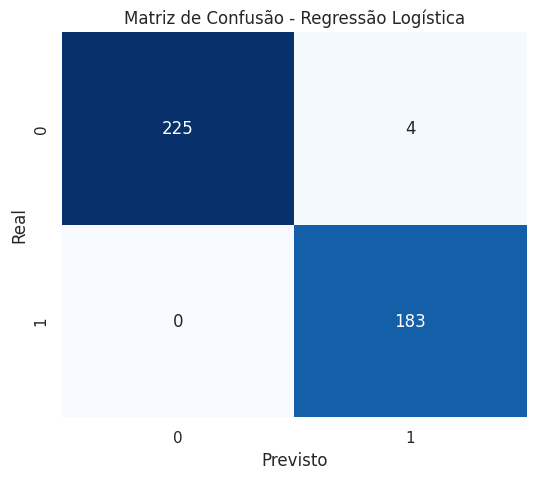


Relatório de Classificação:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       229
           1       0.98      1.00      0.99       183

    accuracy                           0.99       412
   macro avg       0.99      0.99      0.99       412
weighted avg       0.99      0.99      0.99       412



In [15]:
# 1. Selecionando o vencedor baseado na validação cruzada
if grid_lr.best_score_ > nb_scores.mean():
    final_model = best_lr_model
    nome_modelo = "Regressão Logística"
else:
    final_model = nb_model
    nome_modelo = "Naive Bayes"

print(f"MODELO ESCOLHIDO: {nome_modelo}")

# 2. Avaliação Final nos dados de Teste (dados nunca vistos)
y_pred = final_model.predict(X_test)

# 3. Gerando a Matriz de Confusão
cm = confusion_matrix(y_test, y_pred)

# 4. Plotando a Matriz
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title(f"Matriz de Confusão - {nome_modelo}")
plt.xlabel("Previsto")
plt.ylabel("Real")
plt.show()

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))

Célula 7: Salvando o Modelo (Pickle)

Salva o modelo treinado em um arquivo .pkl para uso futuro.

In [16]:
nome_arquivo = 'modelo_banknote_final.pkl'

# Salvando o modelo em disco
with open(nome_arquivo, 'wb') as arquivo:
    pickle.dump(final_model, arquivo)

print(f"Modelo salvo com sucesso como '{nome_arquivo}'")

# --- Teste de carregamento (opcional) ---
# Carregando para garantir que funcionou
with open(nome_arquivo, 'rb') as arquivo:
    modelo_carregado = pickle.load(arquivo)

acc_teste = modelo_carregado.score(X_test, y_test)
print(f"Modelo carregado e testado. Acurácia no teste: {acc_teste:.4f}")

Modelo salvo com sucesso como 'modelo_banknote_final.pkl'
Modelo carregado e testado. Acurácia no teste: 0.9903
